### LangGraph Tutorial
1. Initialize the model and tools
2. Initialize graph with state
3. Define graph nodes.
4. Define entry point and graph edges
5. Compile the graph.
6. Execute the graph.

In [ ]:
# Install langgraph
!pip install -U langgraph

#### Initialization model

In [1]:
import vertexai
import os
import IPython
# load google access config file
credential_path="/Users/gongbiao/Code/vertex-ai/config/google_access_token_cp.json"
if os.path.exists(credential_path):
    print(f"the config load success")
else:
    print("config file does'not exists!")
    
# init vertex ai
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

the config load success


In [2]:
# Model
# [Optinal] set proxy
proxy = "http://127.0.0.1:8889"
os.environ["HTTP_PROXY"] = proxy
os.environ["HTTPS_PROXY"] = proxy
os.environ["http_proxy"] = proxy
os.environ["https_proxy"] = proxy
from langchain_google_vertexai import VertexAI


In [3]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_google_vertexai import ChatVertexAI


# Define the tools for the agent to use
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."


tools = [search]

tool_node = ToolNode(tools)

# To use chat vertex ai model
model = ChatVertexAI(model_name="gemini-1.5-pro-001", temperature=0).bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
workflow.add_edge(START, "agent")

# We now add a condition edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next ,we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable,
# Node that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="What is the weather in sf")]},
    config={"configurable": {"thread_id": 42}}
)
print(final_state["messages"][-1].content)



It's 60 degrees and foggy.


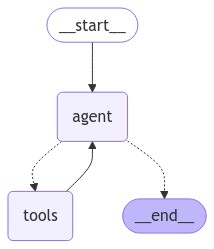

In [5]:
# Visualize the graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [39]:
# Now when we pass the same "thread_id", the conversation context is retained via the saved state (i.e. stored list of messages)
final_state = app.invoke(
    {"messages": [HumanMessage(content="What about chengdu?")]},
    config={"configurable": {"thread_id": 42}}
)
print(final_state["messages"][-1].content)


[HumanMessage(content='What is the weather in sf', additional_kwargs={}, response_metadata={}, id='93249f8a-dd2a-4ebb-9e10-083331b3e542'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_LOW'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}], 'usage_metadata': {'prompt_token_count': 15, 'candidates_token_count': 5, 'total_token_count': 20, 'cached_content_token_count': 0}